In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
import time

import warnings
warnings.filterwarnings("ignore")

import poppy
import hcipy as hci

import wfsc_tests as wfsc
wfsc.math_module.update_np(np)
wfsc.math_module.update_scipy(scipy)

import misc_funs as misc

from matplotlib.colors import ListedColormap
#Blue to Red Color scale for S1 and S2
colmap = np.zeros((255,3));
# Red
colmap[126:183,0]= np.linspace(0,1,57);
colmap[183:255,0]= 1;
# Green
colmap[0:96,1] = np.linspace(1,0,96);
colmap[158:255,1]= np.linspace(0,1,97);
# Blue
colmap[0:71,2] = 1;
colmap[71:128,2]= np.linspace(1,0,57);
colmap2 = colmap[128:,:]
colmap = ListedColormap(colmap)

In [33]:
class CORO():

    def __init__(self, 
                 wavelength=None, 
                 dm1_dm2=200e-3*u.m,
                 aberration_distance=100e-3*u.m,
                 influence_functions=None,
                ):
        
        self.wavelength_c = 575e-9*u.m
        self.wavelength = self.wavelength_c if wavelength is None else wavelength
        self.f = 500*u.mm
        
        self.dm_diam = 10.2*u.mm
        self.dm1_dm2 = dm1_dm2
        
        self.FN = (self.dm_diam**2/self.dm1_dm2/self.wavelength).decompose()
        
        # define the grids
        self.npix = 256
        self.oversample = 2
        self.spatial_resolution = self.f.to_value(u.m) * self.wavelength.to_value(u.m) / self.dm_diam.to_value(u.m)
        self.npsf = 64
        self.psf_pixelscale_lamD = self.spatial_resolution/self.f.to_value(u.m)*(self.dm_diam/self.wavelength_c).decompose().value/2
        
        self.pupil_grid = hci.make_pupil_grid(self.npix*self.oversample, self.dm_diam.to_value(u.m) * self.oversample)
        self.focal_grid = hci.make_focal_grid(2, 16, spatial_resolution=self.spatial_resolution)
        self.prop = hci.FraunhoferPropagator(self.pupil_grid, self.focal_grid, self.f.to_value(u.m))

        self.aperture = hci.Field(np.exp(-(self.pupil_grid.as_('polar').r / (0.5 * self.dm_diam.to_value(u.m)))**30), self.pupil_grid)
        
        # define the DMs
        self.Nact = 34
        self.actuator_spacing = 1.00 / self.Nact * self.dm_diam.to_value(u.m)
        
        # make the aberrations of the system (make sure to remove tip-tilt)
        aberration_ptv = 0.02 * self.wavelength.to_value(u.m)
        tip_tilt = hci.make_zernike_basis(3, self.dm_diam.to_value(u.m), self.pupil_grid, starting_mode=2)
        wfe = hci.SurfaceAberration(self.pupil_grid, aberration_ptv, self.dm_diam.to_value(u.m), remove_modes=tip_tilt, exponent=-3)
        self.aberration_distance_m = aberration_distance.to_value(u.m)
        self.wfe_at_distance = hci.SurfaceAberrationAtDistance(wfe, self.aberration_distance_m)
        
        # make the coronagraph model
        self.coronagraph = hci.PerfectCoronagraph(self.aperture, order=6)
        
        if influence_functions is not None: 
            self.init_dms(influence_functions)
            
    def init_dms(self, influence_functions):
        self.DM1 = hci.DeformableMirror(influence_functions)
        self.DM2 = hci.DeformableMirror(influence_functions)

        self.prop_between_dms = hci.FresnelPropagator(self.pupil_grid, self.dm1_dm2.to_value(u.m))
        
        self.dm_mask = np.ones((self.Nact,self.Nact), dtype=bool)
        xx = (np.linspace(0, self.Nact-1, self.Nact) - self.Nact/2 + 1/2) * self.actuator_spacing*2
        x,y = np.meshgrid(xx,xx)
        r = np.sqrt(x**2 + y**2)
        self.dm_mask[r>0.0105] = 0 # had to set the threshold to 10.5 instead of 10.2 to include edge actuators
        
#         self.dm_zernikes = poppy.zernike.arbitrary_basis(self.dm_mask, nterms=15, outside=0)
        self.dm_zernikes = poppy.zernike.arbitrary_basis(cp.array(self.dm_mask), nterms=15, outside=0).get()
        
        
    def set_dm1(self, command):
        self.DM1.actuators = command.ravel()
        
    def set_dm2(self, command):
        self.DM2.actuators = command.ravel()
        
    def add_dm1(self, command):
        self.DM1.actuators += command.ravel()
        
    def add_dm2(self, command):
        self.DM2.actuators += command.ravel()
        
    def get_dm1(self):
        return self.DM1.actuators.reshape(self.Nact, self.Nact)
        
    def get_dm2(self):
        return self.DM2.actuators.reshape(self.Nact, self.Nact)
    
    def reset_dms(self):
        self.DM1.actuators = np.zeros((self.Nact, self.Nact)).ravel()
        self.DM2.actuators = np.zeros((self.Nact, self.Nact)).ravel()
    
    def show_dms(self):
        misc.imshow2(self.DM1.actuators.reshape(c.Nact, c.Nact),
                     self.DM2.actuators.reshape(c.Nact, c.Nact))
        
    def calc_psf(self):
        wf = hci.Wavefront(self.aperture, self.wavelength.to_value(u.m))
        wf = self.wfe_at_distance(wf) # apply aberrations to wavefront
        wf = self.prop_between_dms.backward(self.DM2(self.prop_between_dms.forward(self.DM1(wf)))) # apply DMs
        wf = self.prop(self.coronagraph(wf))
        psf_wf = wf.real.shaped + 1j*wf.imag.shaped

        return np.array(psf_wf)

    def snap(self):
        wf = hci.Wavefront(self.aperture, self.wavelength.to_value(u.m))
        wf = self.wfe_at_distance(wf) # apply aberrations to wavefront
        wf = self.prop_between_dms.backward(self.DM2(self.prop_between_dms.forward(self.DM1(wf)))) # apply DMs
        im = self.prop(self.coronagraph(wf))

        return np.array(im.intensity.shaped)
    
c = CORO()


In [6]:
influence_functions = hci.make_gaussian_influence_functions(c.pupil_grid, c.Nact, c.actuator_spacing)

In [15]:
c = CORO(influence_functions=influence_functions,
         aberration_distance_m=400e-3)

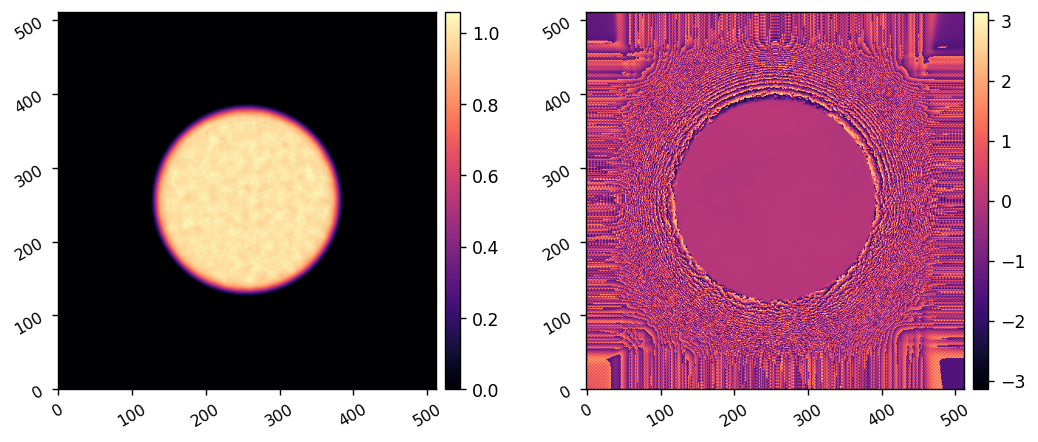

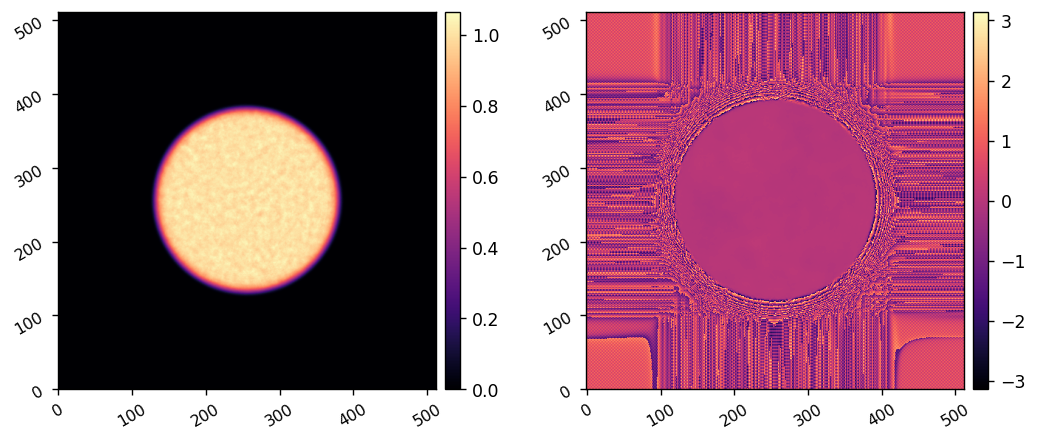

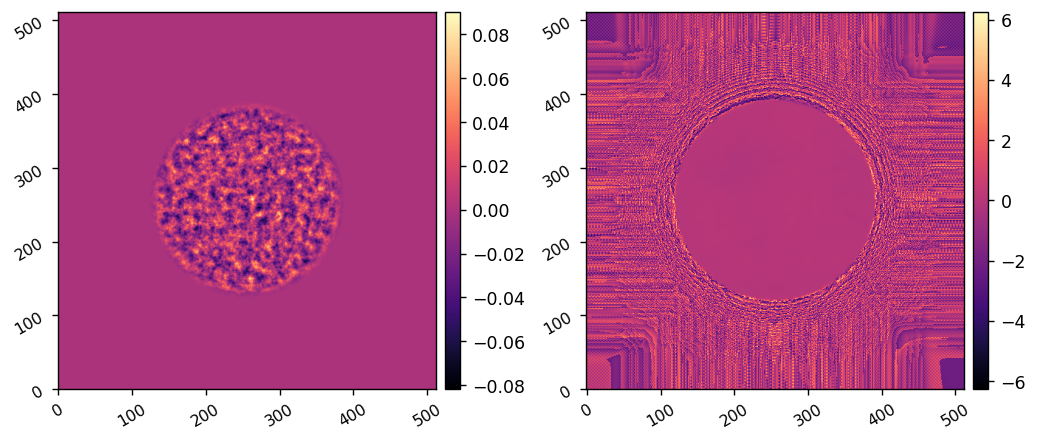

In [34]:
c = CORO(influence_functions=influence_functions,
         aberration_distance=500e-3*u.m)
aberrated_pupil_1 = c.wfe_at_distance(hci.Wavefront(c.aperture, c.wavelength.to_value(u.m)))
misc.imshow2(aberrated_pupil_1.intensity.shaped, aberrated_pupil_1.phase.shaped)

c = CORO(influence_functions=influence_functions,
         aberration_distance=200e-3*u.m)
aberrated_pupil_2 = c.wfe_at_distance(hci.Wavefront(c.aperture, c.wavelength.to_value(u.m)))
misc.imshow2(aberrated_pupil_2.intensity.shaped, aberrated_pupil_2.phase.shaped)

misc.imshow2(aberrated_pupil_1.intensity.shaped - aberrated_pupil_2.intensity.shaped,
             aberrated_pupil_1.phase.shaped - aberrated_pupil_2.phase.shaped)


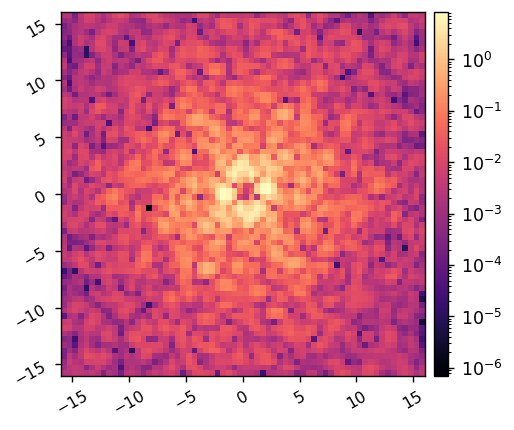

In [35]:
Nact = c.Nact
npsf = c.npsf

c.reset_dms()
ref_im = c.snap()

misc.imshow1(ref_im, lognorm=True, pxscl=c.psf_pixelscale_lamD)

# define the dark hole region

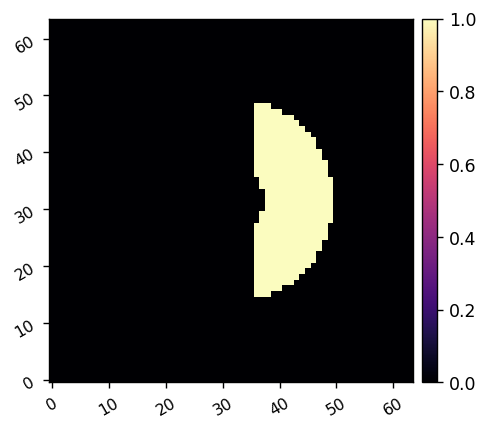

In [36]:
reload(wfsc)
reload(wfsc.utils)
reload(wfsc.imshows)
xfp = (np.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*c.psf_pixelscale_lamD
fpx,fpy = np.meshgrid(xfp,xfp)
fpr = np.sqrt(fpx**2 + fpy**2)
    
iwa = 3
owa = 9
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
dark_mask = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

probe_amp = 3e-8
calib_amp = 5e-9

In [37]:
reload(wfsc.efc_1dm)

c.reset_dms()

epsilon = 1e-9 # poke amplitudes (DM surface)
jac = wfsc.efc_1dm.build_jacobian(c, epsilon, dark_mask.flatten(), display=False)

	Calculated response for mode 1/952. Elapsed time=0.310 sec.
	Calculated response for mode 2/952. Elapsed time=0.618 sec.
	Calculated response for mode 3/952. Elapsed time=0.926 sec.
	Calculated response for mode 4/952. Elapsed time=1.235 sec.
	Calculated response for mode 5/952. Elapsed time=1.543 sec.
	Calculated response for mode 6/952. Elapsed time=1.852 sec.
	Calculated response for mode 7/952. Elapsed time=2.160 sec.
	Calculated response for mode 8/952. Elapsed time=2.469 sec.
	Calculated response for mode 9/952. Elapsed time=2.778 sec.
	Calculated response for mode 10/952. Elapsed time=3.086 sec.
	Calculated response for mode 11/952. Elapsed time=3.393 sec.
	Calculated response for mode 12/952. Elapsed time=3.701 sec.
	Calculated response for mode 13/952. Elapsed time=4.009 sec.
	Calculated response for mode 14/952. Elapsed time=4.317 sec.
	Calculated response for mode 15/952. Elapsed time=4.626 sec.
	Calculated response for mode 16/952. Elapsed time=4.934 sec.
	Calculated respo

	Calculated response for mode 132/952. Elapsed time=40.929 sec.
	Calculated response for mode 133/952. Elapsed time=41.238 sec.
	Calculated response for mode 134/952. Elapsed time=41.548 sec.
	Calculated response for mode 135/952. Elapsed time=41.857 sec.
	Calculated response for mode 136/952. Elapsed time=42.167 sec.
	Calculated response for mode 137/952. Elapsed time=42.476 sec.
	Calculated response for mode 138/952. Elapsed time=42.786 sec.
	Calculated response for mode 139/952. Elapsed time=43.096 sec.
	Calculated response for mode 140/952. Elapsed time=43.407 sec.
	Calculated response for mode 141/952. Elapsed time=43.716 sec.
	Calculated response for mode 142/952. Elapsed time=44.026 sec.
	Calculated response for mode 143/952. Elapsed time=44.335 sec.
	Calculated response for mode 144/952. Elapsed time=44.645 sec.
	Calculated response for mode 145/952. Elapsed time=44.955 sec.
	Calculated response for mode 146/952. Elapsed time=45.265 sec.
	Calculated response for mode 147/952. E

	Calculated response for mode 261/952. Elapsed time=80.884 sec.
	Calculated response for mode 262/952. Elapsed time=81.194 sec.
	Calculated response for mode 263/952. Elapsed time=81.504 sec.
	Calculated response for mode 264/952. Elapsed time=81.813 sec.
	Calculated response for mode 265/952. Elapsed time=82.123 sec.
	Calculated response for mode 266/952. Elapsed time=82.432 sec.
	Calculated response for mode 267/952. Elapsed time=82.742 sec.
	Calculated response for mode 268/952. Elapsed time=83.051 sec.
	Calculated response for mode 269/952. Elapsed time=83.361 sec.
	Calculated response for mode 270/952. Elapsed time=83.670 sec.
	Calculated response for mode 271/952. Elapsed time=83.980 sec.
	Calculated response for mode 272/952. Elapsed time=84.289 sec.
	Calculated response for mode 273/952. Elapsed time=84.599 sec.
	Calculated response for mode 274/952. Elapsed time=84.909 sec.
	Calculated response for mode 275/952. Elapsed time=85.219 sec.
	Calculated response for mode 276/952. E

	Calculated response for mode 388/952. Elapsed time=120.224 sec.
	Calculated response for mode 389/952. Elapsed time=120.534 sec.
	Calculated response for mode 390/952. Elapsed time=120.844 sec.
	Calculated response for mode 391/952. Elapsed time=121.154 sec.
	Calculated response for mode 392/952. Elapsed time=121.463 sec.
	Calculated response for mode 393/952. Elapsed time=121.773 sec.
	Calculated response for mode 394/952. Elapsed time=122.082 sec.
	Calculated response for mode 395/952. Elapsed time=122.392 sec.
	Calculated response for mode 396/952. Elapsed time=122.702 sec.
	Calculated response for mode 397/952. Elapsed time=123.012 sec.
	Calculated response for mode 398/952. Elapsed time=123.322 sec.
	Calculated response for mode 399/952. Elapsed time=123.632 sec.
	Calculated response for mode 400/952. Elapsed time=123.942 sec.
	Calculated response for mode 401/952. Elapsed time=124.252 sec.
	Calculated response for mode 402/952. Elapsed time=124.561 sec.
	Calculated response for 

	Calculated response for mode 515/952. Elapsed time=159.536 sec.
	Calculated response for mode 516/952. Elapsed time=159.846 sec.
	Calculated response for mode 517/952. Elapsed time=160.155 sec.
	Calculated response for mode 518/952. Elapsed time=160.465 sec.
	Calculated response for mode 519/952. Elapsed time=160.774 sec.
	Calculated response for mode 520/952. Elapsed time=161.083 sec.
	Calculated response for mode 521/952. Elapsed time=161.392 sec.
	Calculated response for mode 522/952. Elapsed time=161.702 sec.
	Calculated response for mode 523/952. Elapsed time=162.012 sec.
	Calculated response for mode 524/952. Elapsed time=162.321 sec.
	Calculated response for mode 525/952. Elapsed time=162.630 sec.
	Calculated response for mode 526/952. Elapsed time=162.939 sec.
	Calculated response for mode 527/952. Elapsed time=163.247 sec.
	Calculated response for mode 528/952. Elapsed time=163.556 sec.
	Calculated response for mode 529/952. Elapsed time=163.865 sec.
	Calculated response for 

	Calculated response for mode 642/952. Elapsed time=198.914 sec.
	Calculated response for mode 643/952. Elapsed time=199.223 sec.
	Calculated response for mode 644/952. Elapsed time=199.533 sec.
	Calculated response for mode 645/952. Elapsed time=199.842 sec.
	Calculated response for mode 646/952. Elapsed time=200.152 sec.
	Calculated response for mode 647/952. Elapsed time=200.462 sec.
	Calculated response for mode 648/952. Elapsed time=200.771 sec.
	Calculated response for mode 649/952. Elapsed time=201.080 sec.
	Calculated response for mode 650/952. Elapsed time=201.389 sec.
	Calculated response for mode 651/952. Elapsed time=201.699 sec.
	Calculated response for mode 652/952. Elapsed time=202.008 sec.
	Calculated response for mode 653/952. Elapsed time=202.318 sec.
	Calculated response for mode 654/952. Elapsed time=202.628 sec.
	Calculated response for mode 655/952. Elapsed time=202.938 sec.
	Calculated response for mode 656/952. Elapsed time=203.247 sec.
	Calculated response for 

	Calculated response for mode 769/952. Elapsed time=238.247 sec.
	Calculated response for mode 770/952. Elapsed time=238.557 sec.
	Calculated response for mode 771/952. Elapsed time=238.867 sec.
	Calculated response for mode 772/952. Elapsed time=239.177 sec.
	Calculated response for mode 773/952. Elapsed time=239.487 sec.
	Calculated response for mode 774/952. Elapsed time=239.797 sec.
	Calculated response for mode 775/952. Elapsed time=240.106 sec.
	Calculated response for mode 776/952. Elapsed time=240.416 sec.
	Calculated response for mode 777/952. Elapsed time=240.726 sec.
	Calculated response for mode 778/952. Elapsed time=241.036 sec.
	Calculated response for mode 779/952. Elapsed time=241.345 sec.
	Calculated response for mode 780/952. Elapsed time=241.654 sec.
	Calculated response for mode 781/952. Elapsed time=241.964 sec.
	Calculated response for mode 782/952. Elapsed time=242.273 sec.
	Calculated response for mode 783/952. Elapsed time=242.583 sec.
	Calculated response for 

	Calculated response for mode 896/952. Elapsed time=277.559 sec.
	Calculated response for mode 897/952. Elapsed time=277.868 sec.
	Calculated response for mode 898/952. Elapsed time=278.177 sec.
	Calculated response for mode 899/952. Elapsed time=278.486 sec.
	Calculated response for mode 900/952. Elapsed time=278.796 sec.
	Calculated response for mode 901/952. Elapsed time=279.105 sec.
	Calculated response for mode 902/952. Elapsed time=279.415 sec.
	Calculated response for mode 903/952. Elapsed time=279.724 sec.
	Calculated response for mode 904/952. Elapsed time=280.033 sec.
	Calculated response for mode 905/952. Elapsed time=280.343 sec.
	Calculated response for mode 906/952. Elapsed time=280.652 sec.
	Calculated response for mode 907/952. Elapsed time=280.961 sec.
	Calculated response for mode 908/952. Elapsed time=281.271 sec.
	Calculated response for mode 909/952. Elapsed time=281.580 sec.
	Calculated response for mode 910/952. Elapsed time=281.889 sec.
	Calculated response for 

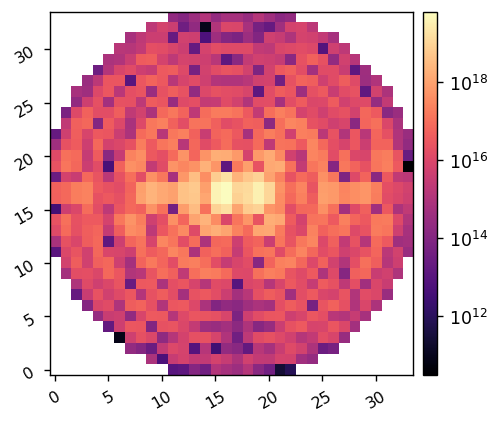

In [38]:
response = wfsc.utils.map_acts_to_dm(abs(jac.sum(axis=0))**2, c.dm_mask)
misc.imshow1(response,lognorm=True)

In [40]:
misc.save_fits('hcipy_efc_1dm_jacobian.fits', jac)

Saved data to:  hcipy_efc_1dm_jacobian.fits


In [52]:
reload(wfsc.utils)

reg_fun = wfsc.utils.beta_reg
reg_conds = np.array([[0, 10, 20, 25, 35, 45],
                      [-1, -2, -3, -2, -6, -3]])

Beginning closed-loop EFC simulation.
Max singular value squared:	 1.0370172338141066e+18
alpha^2:			 1.2869889190959832e+17

	Running iteration 1/50.
	Computing EFC matrix via beta_reg with condition value -1.00e+00


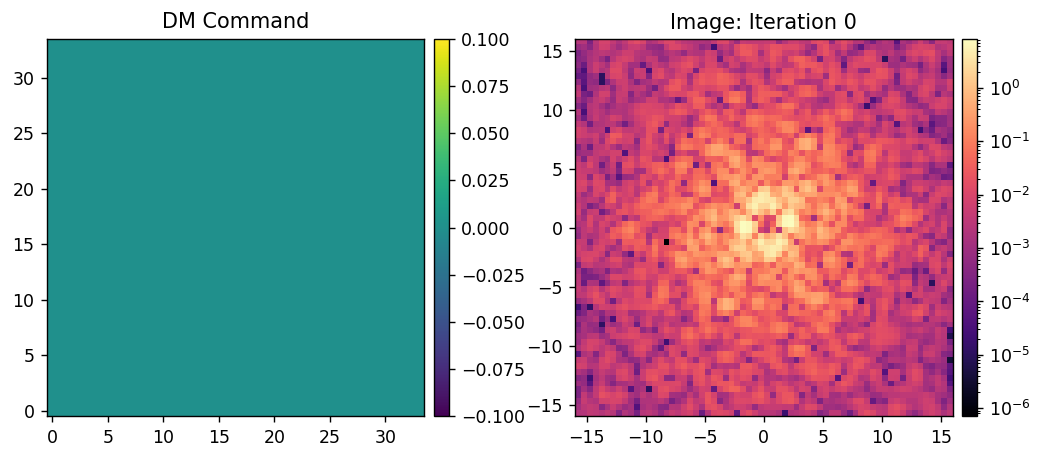

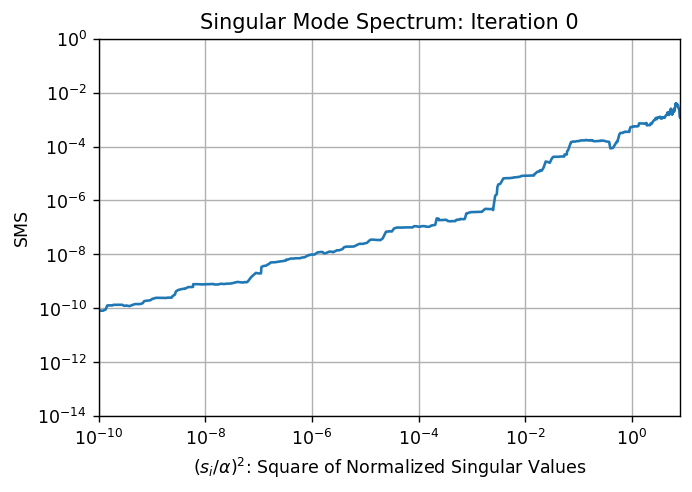

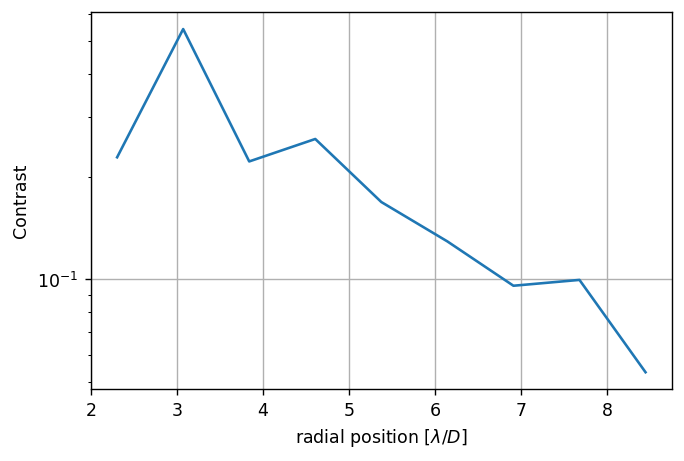

	Running iteration 2/50.


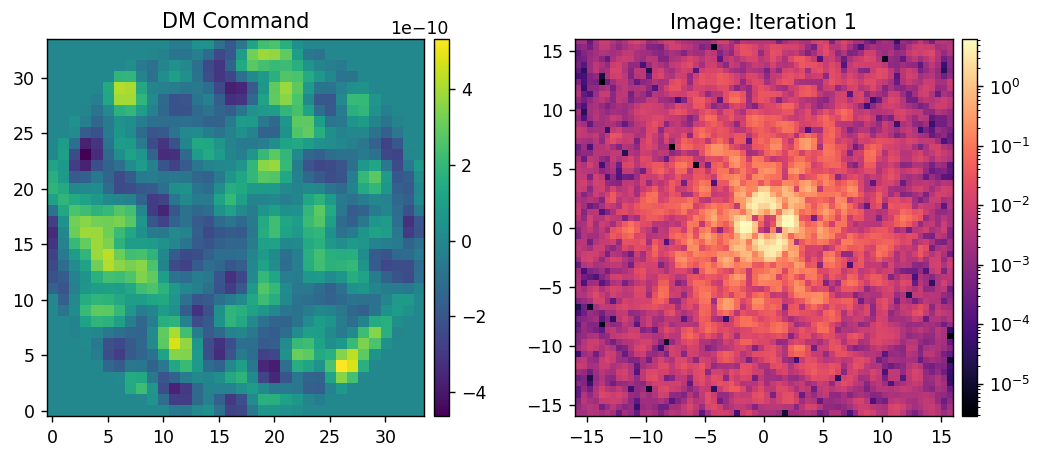

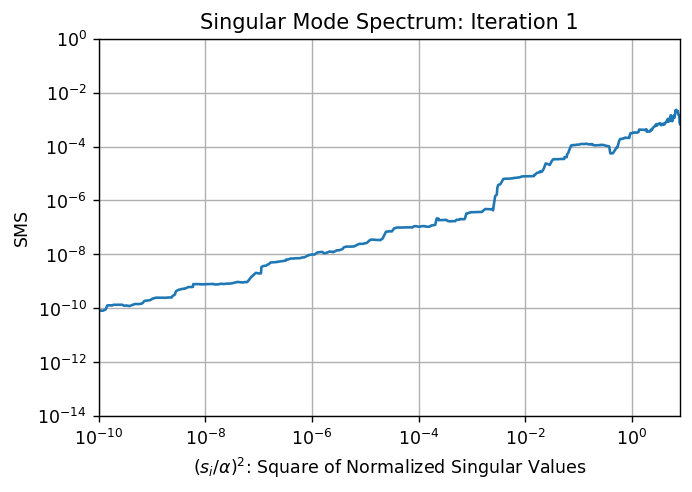

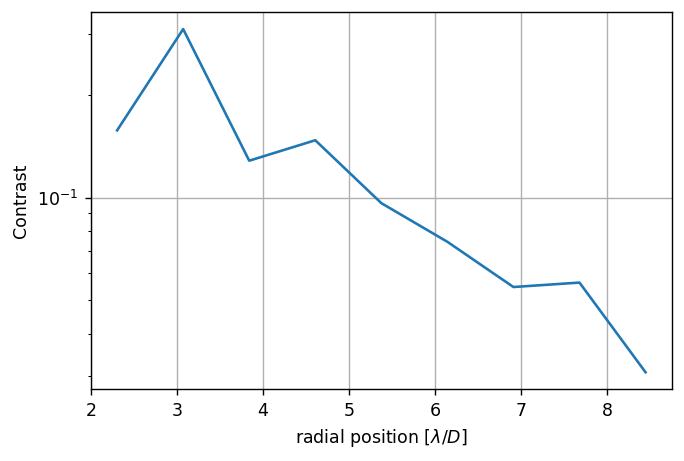

	Running iteration 3/50.


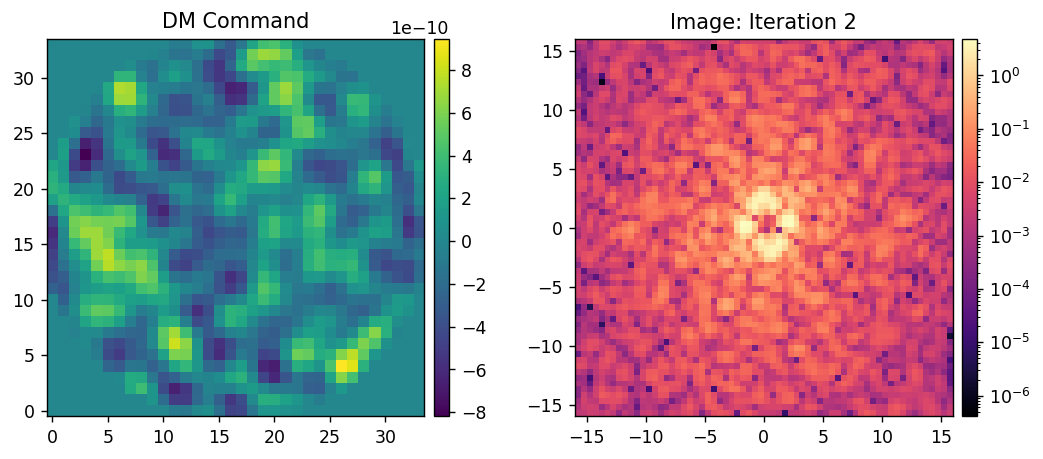

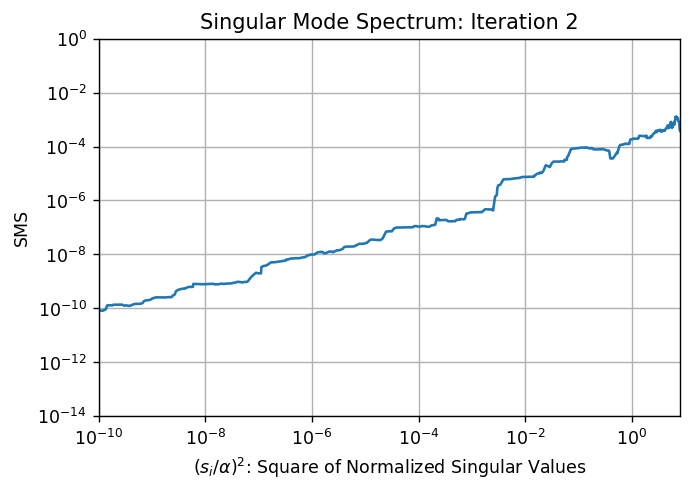

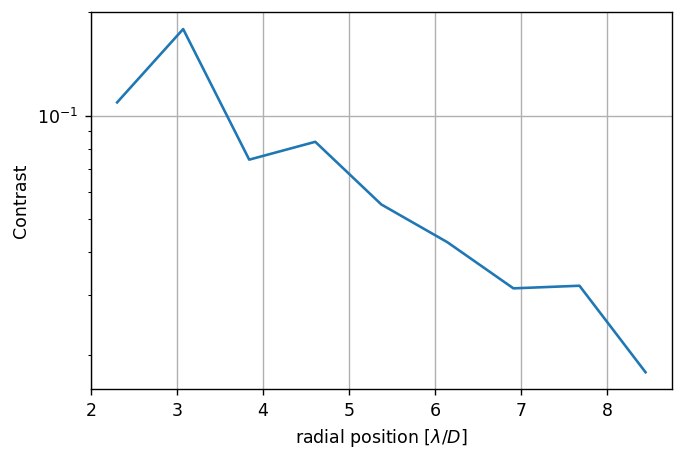

	Running iteration 4/50.


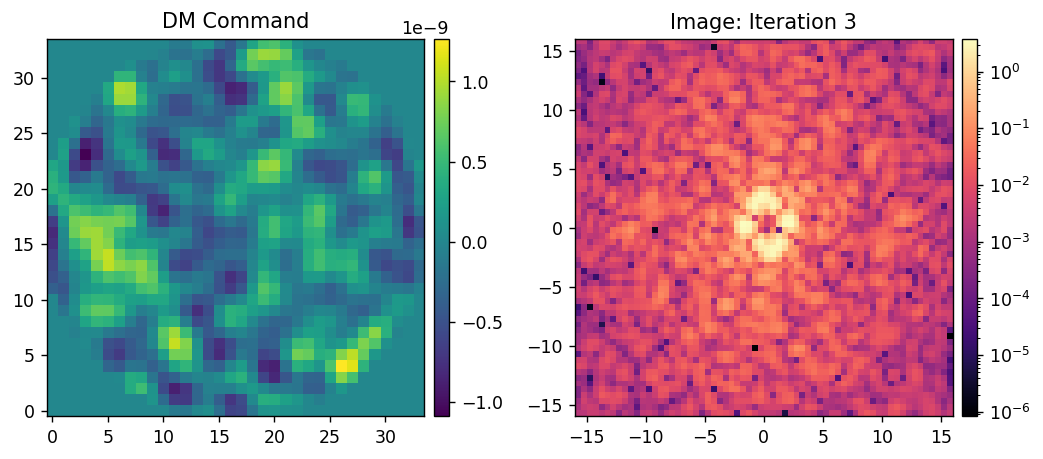

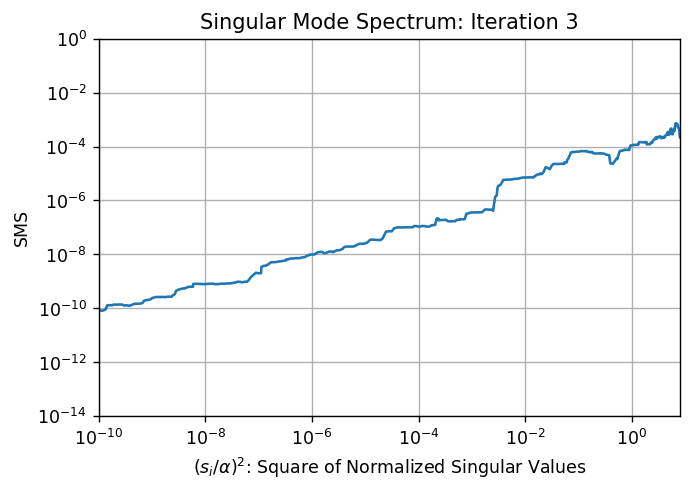

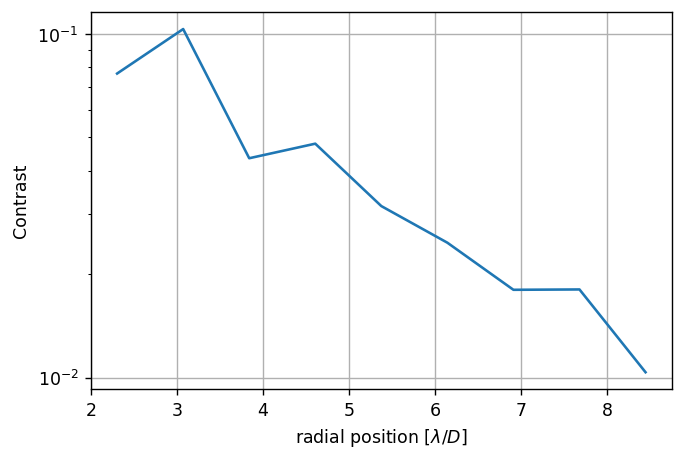

	Running iteration 5/50.


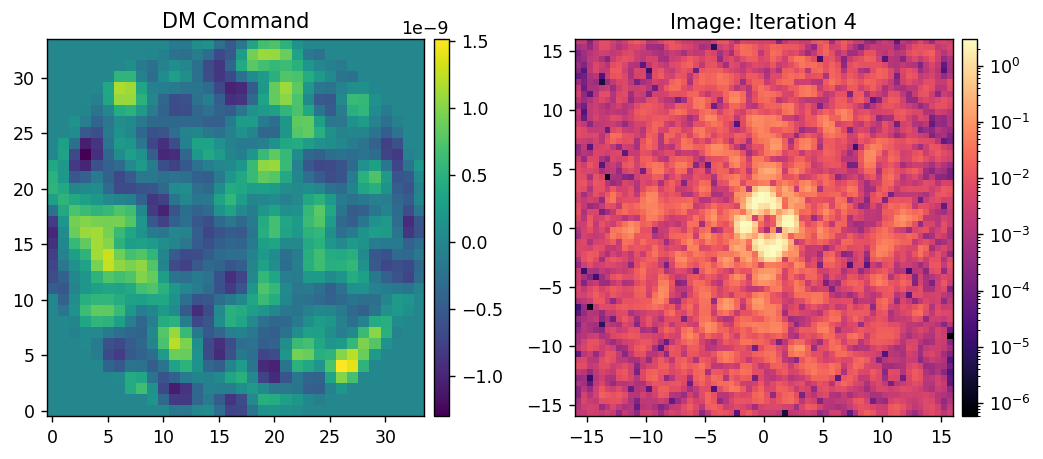

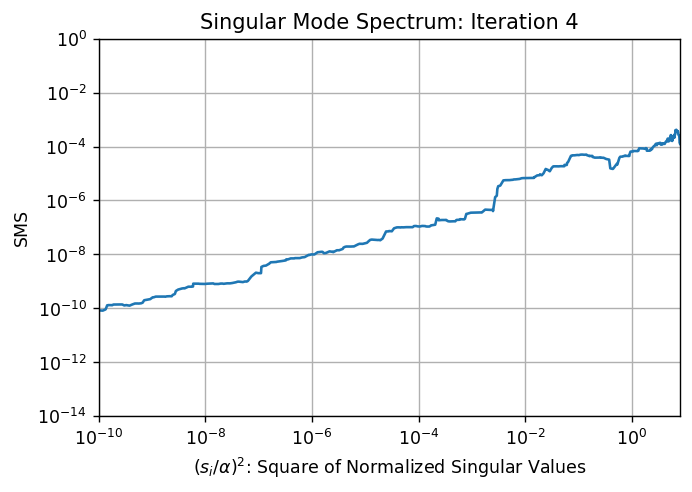

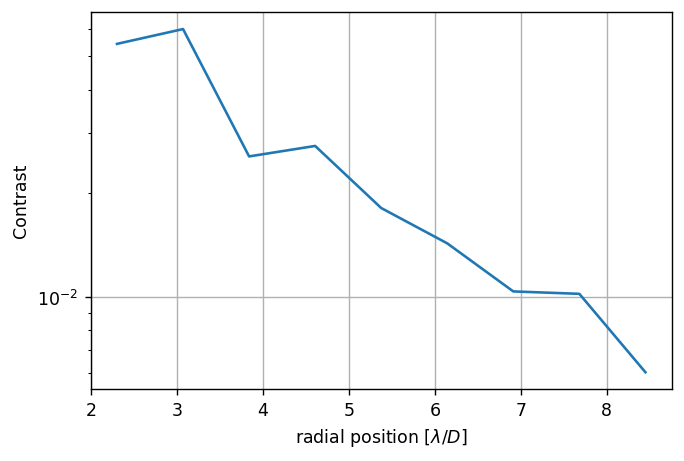

	Running iteration 6/50.


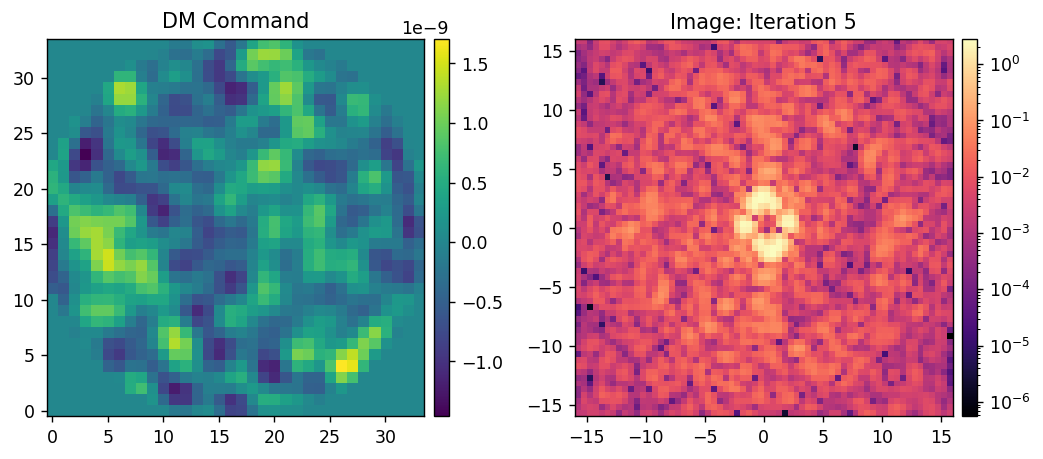

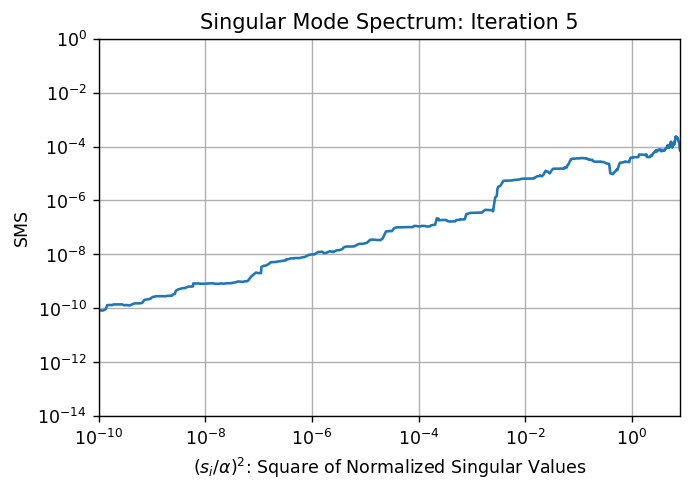

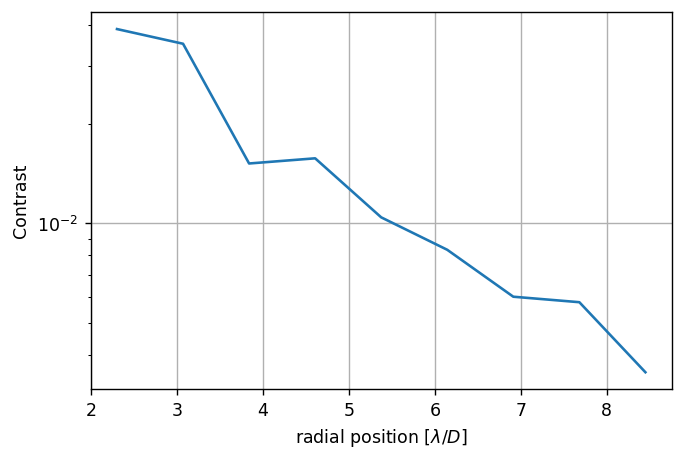

	Running iteration 7/50.


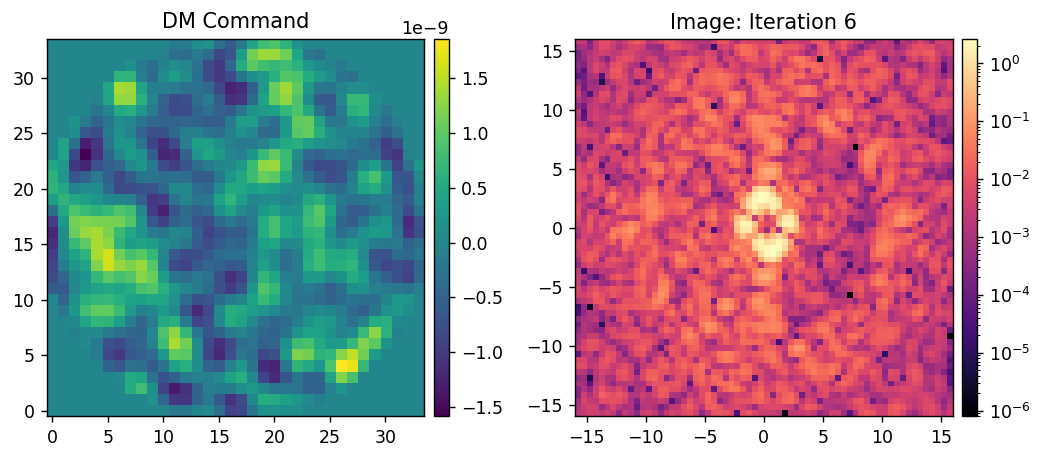

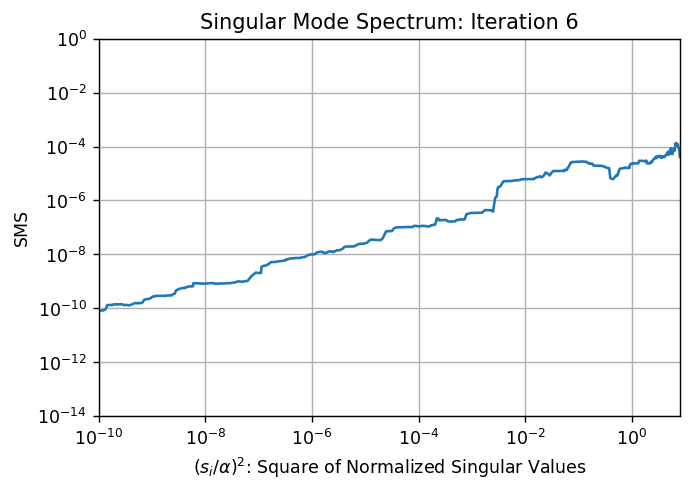

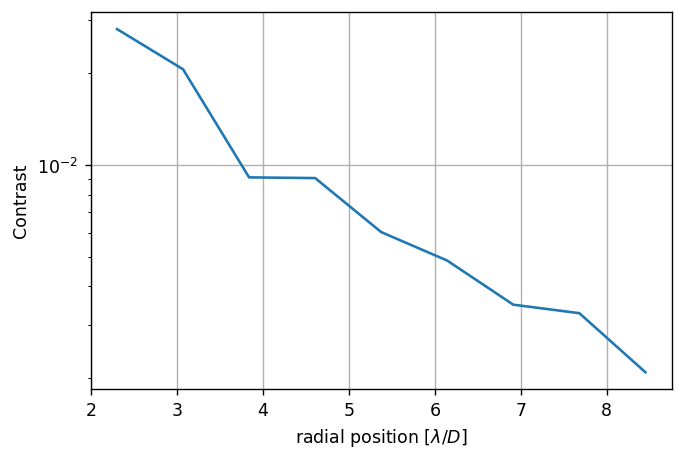

	Running iteration 8/50.


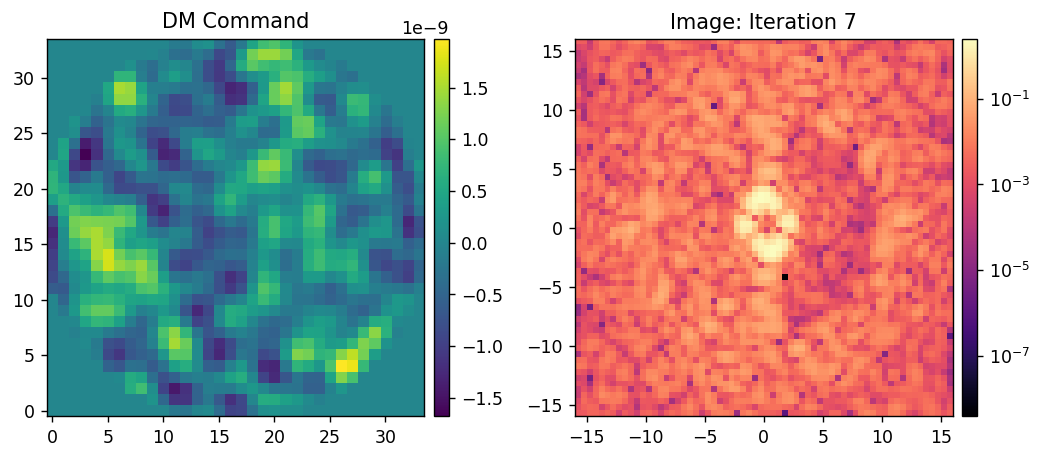

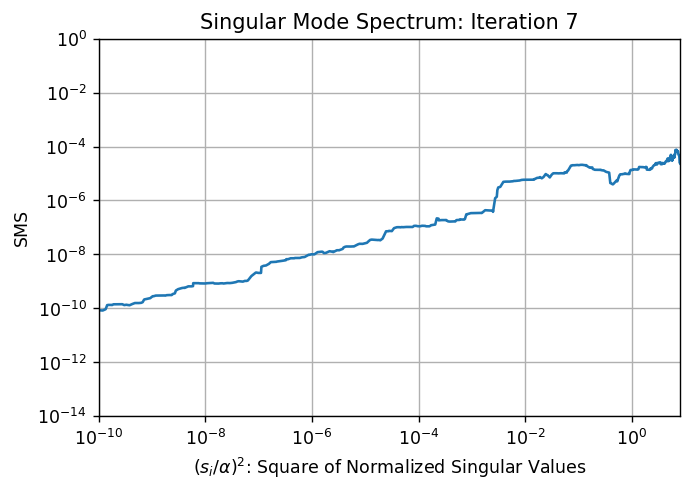

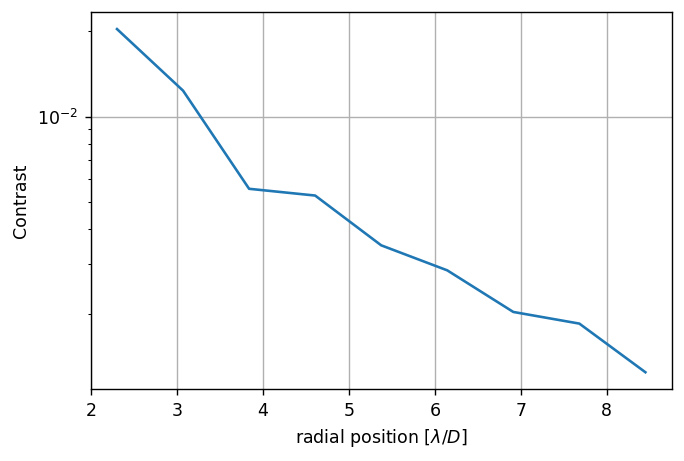

	Running iteration 9/50.


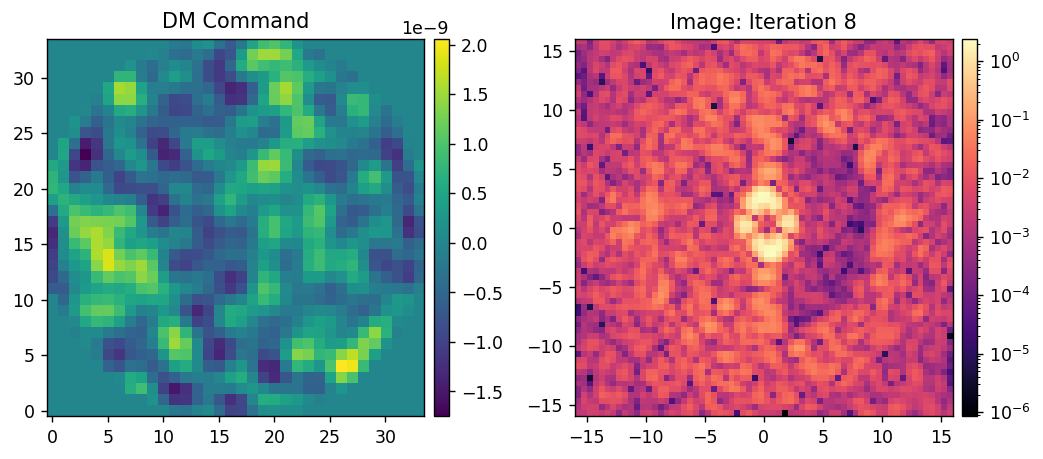

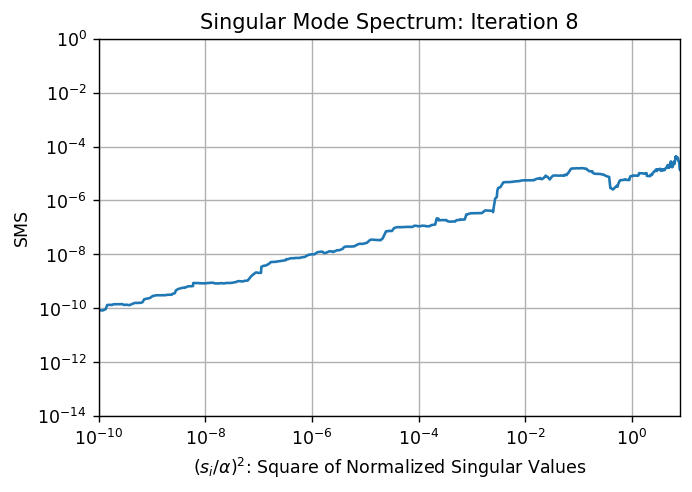

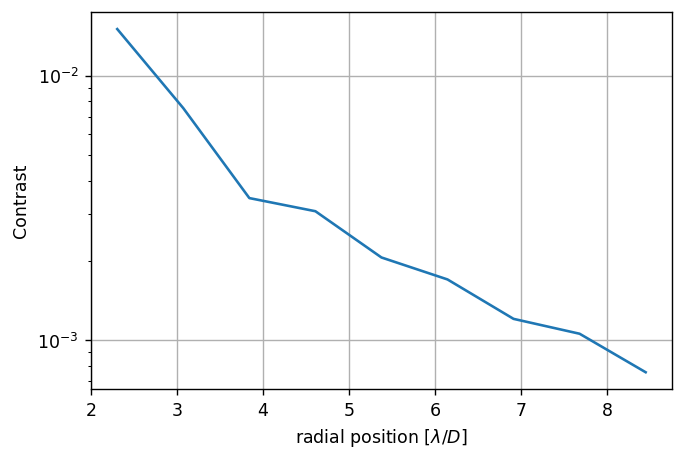

	Running iteration 10/50.


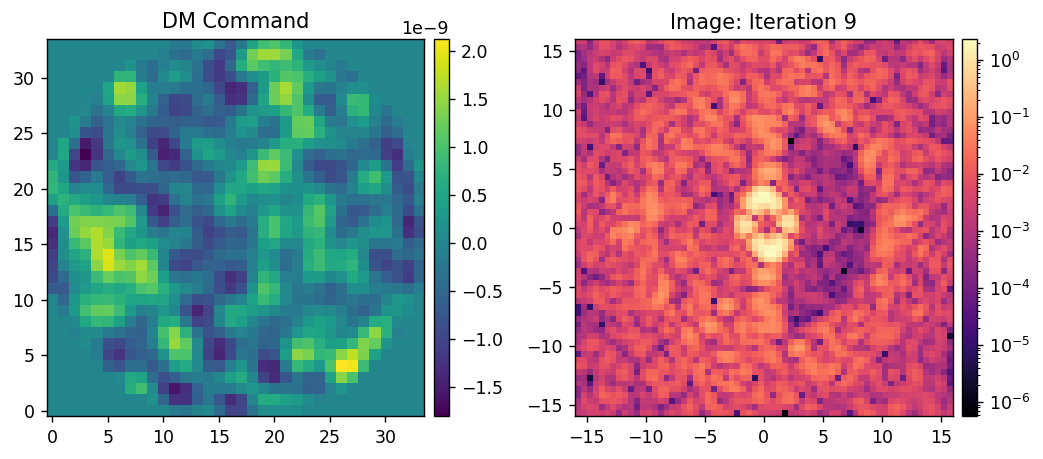

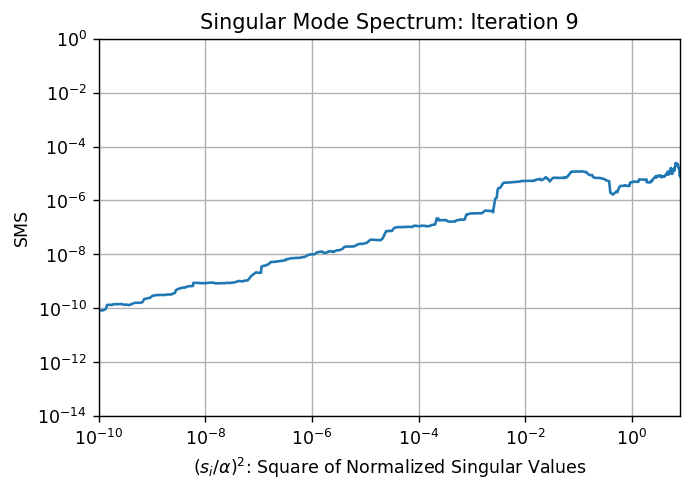

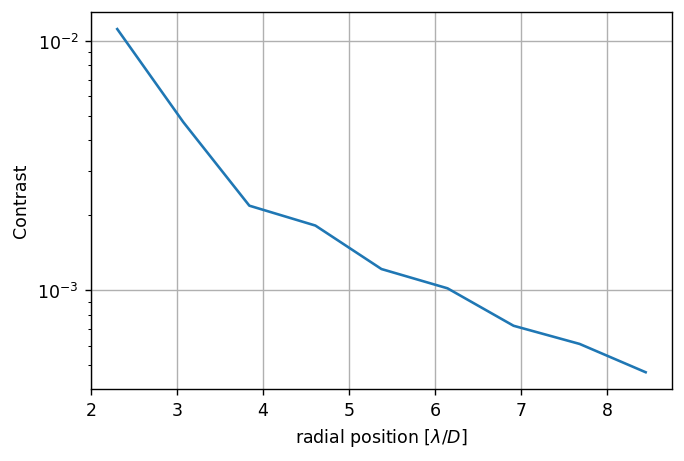

	Running iteration 11/50.
	Computing EFC matrix via beta_reg with condition value -2.00e+00


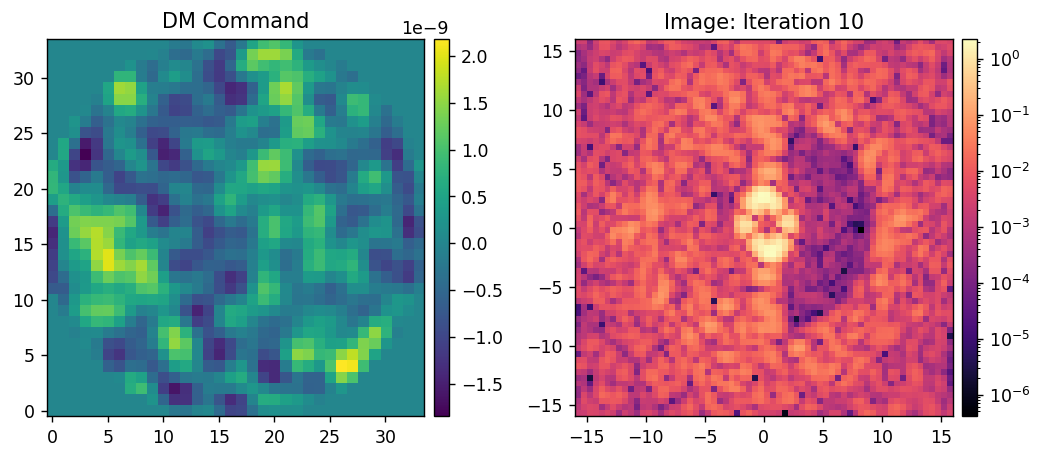

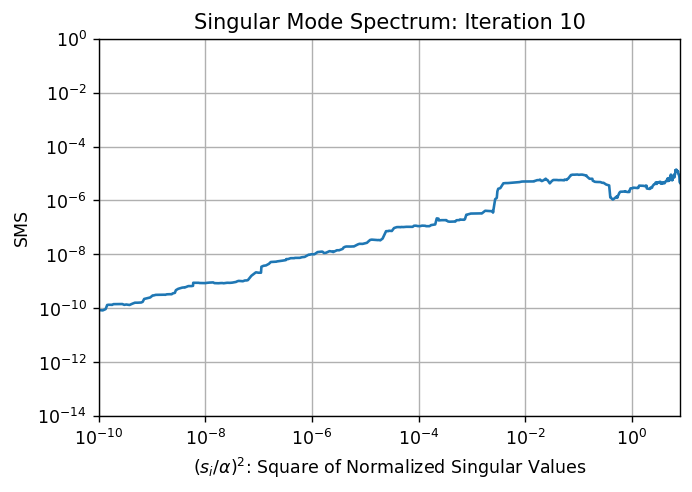

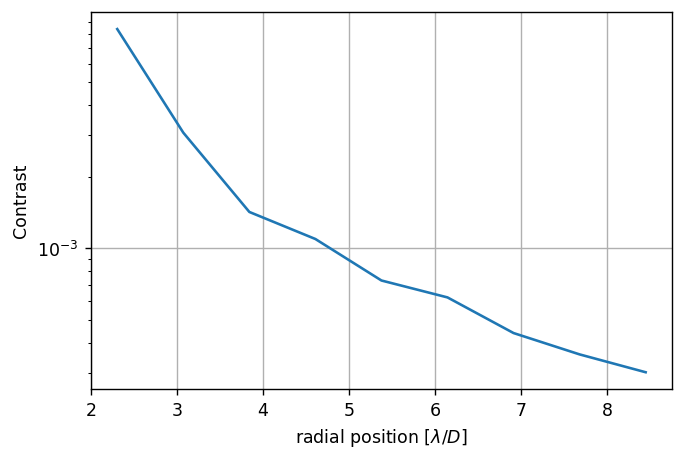

	Running iteration 12/50.


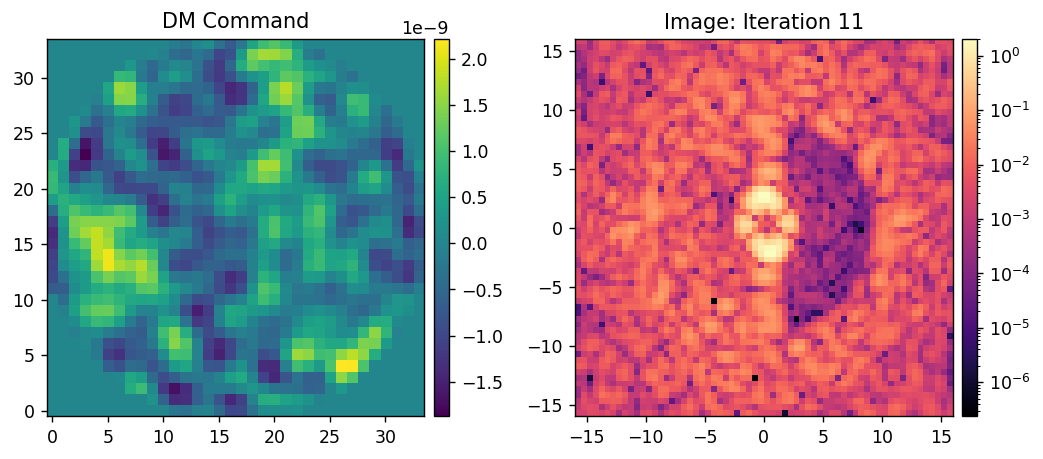

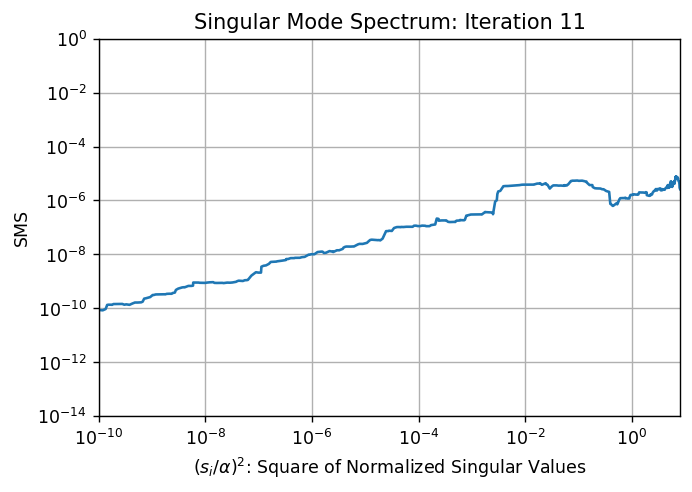

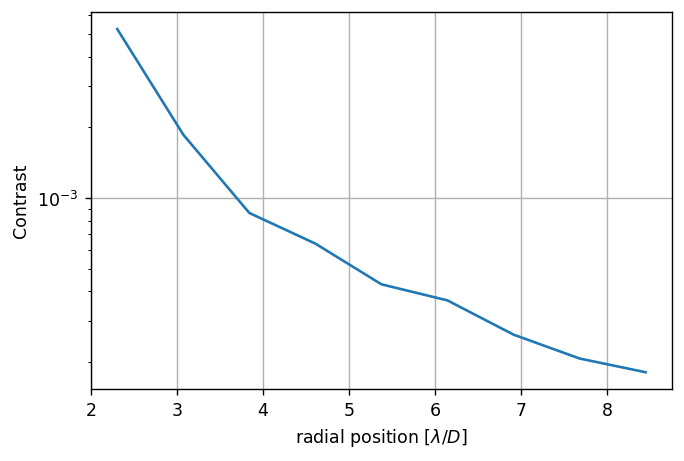

	Running iteration 13/50.


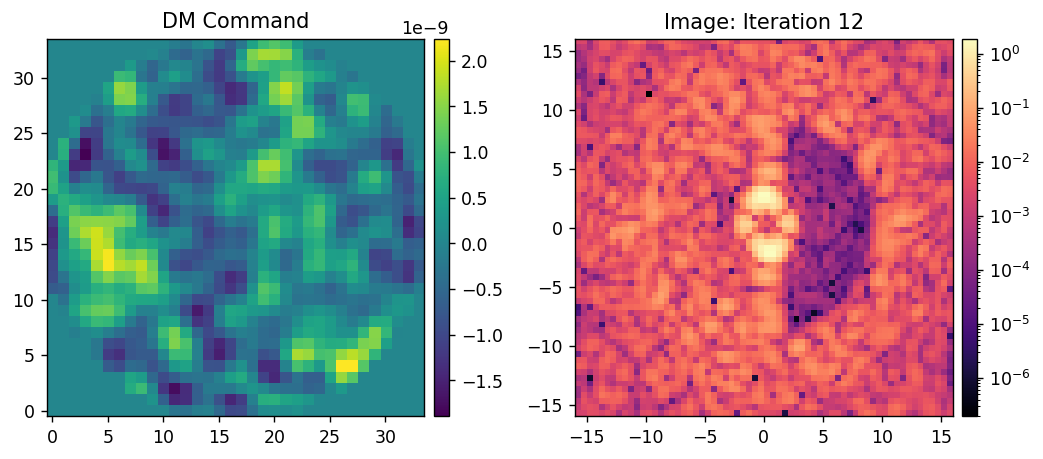

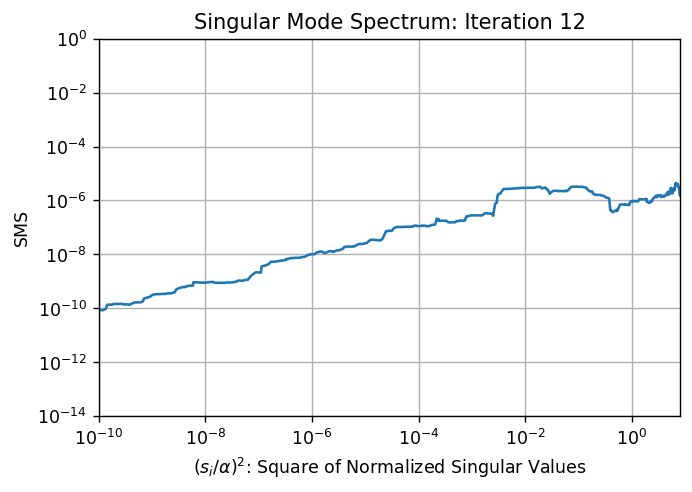

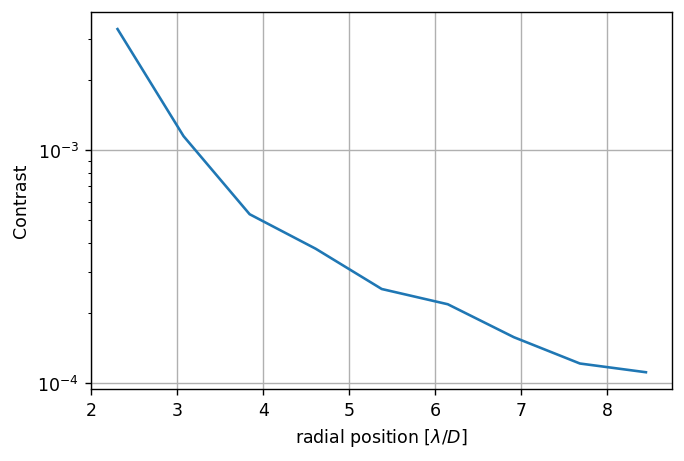

	Running iteration 14/50.


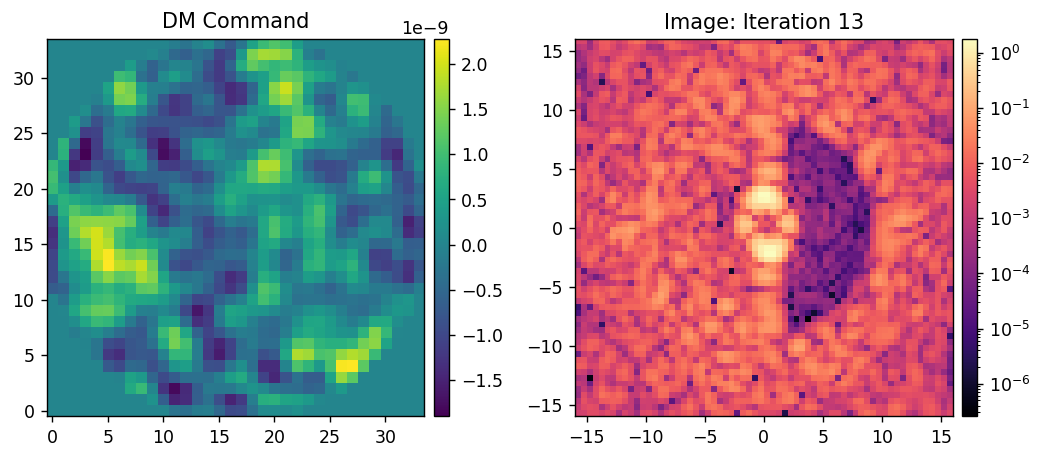

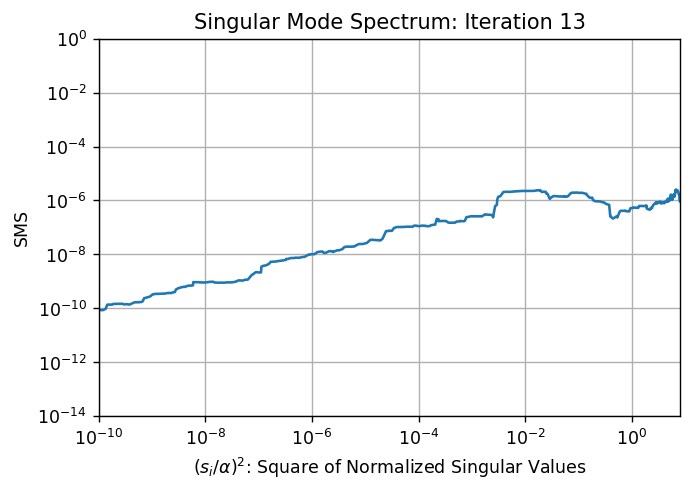

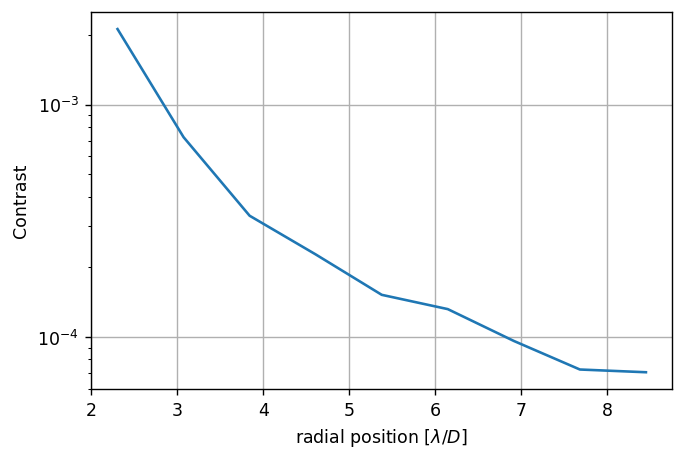

	Running iteration 15/50.


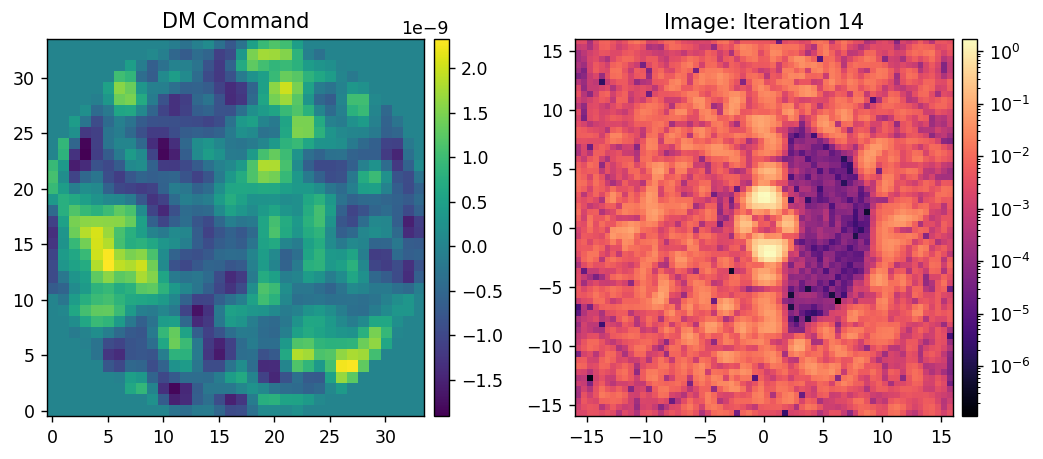

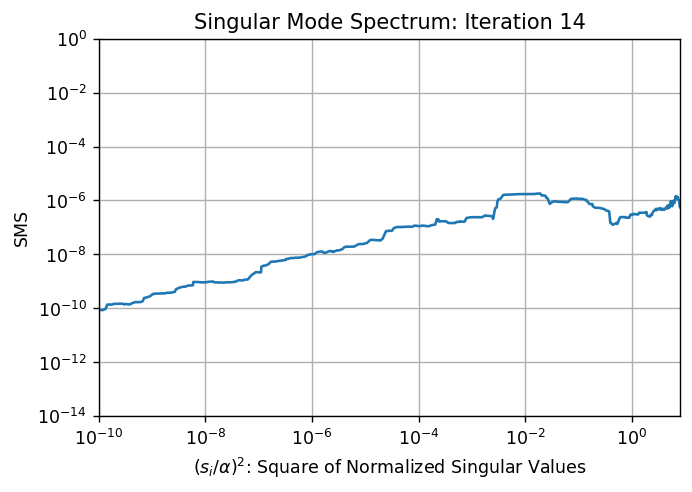

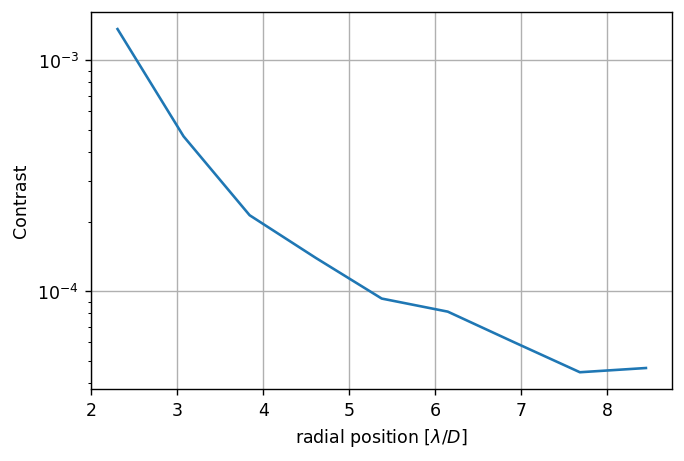

	Running iteration 16/50.


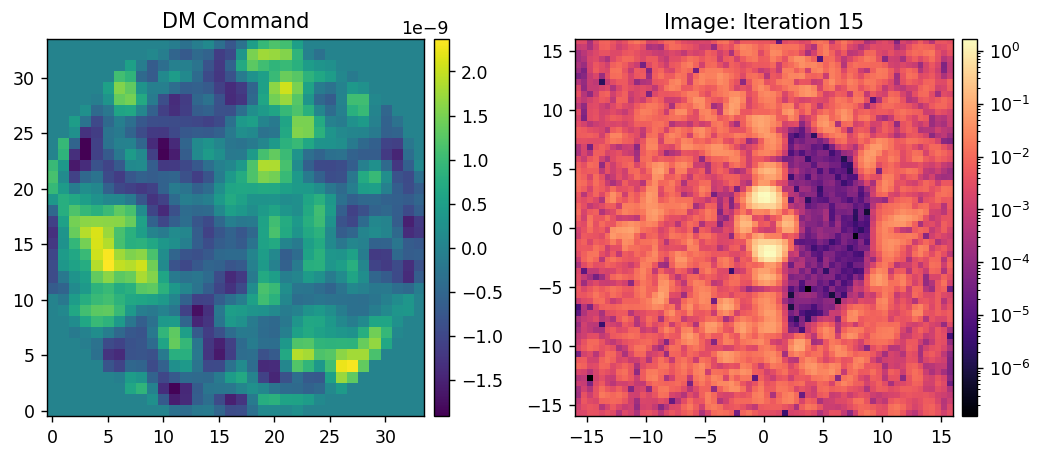

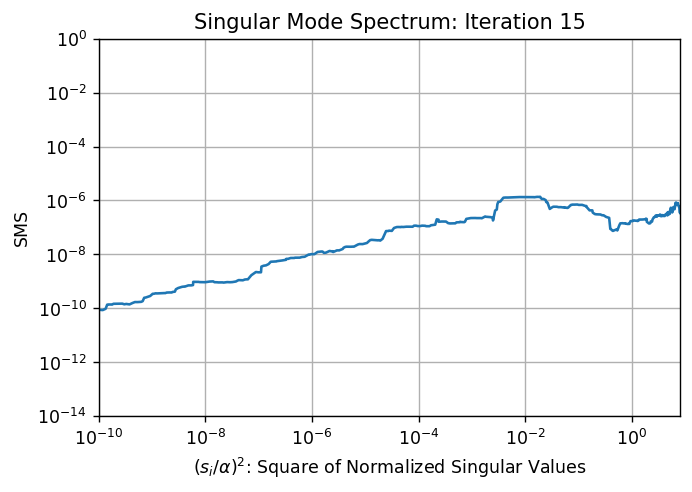

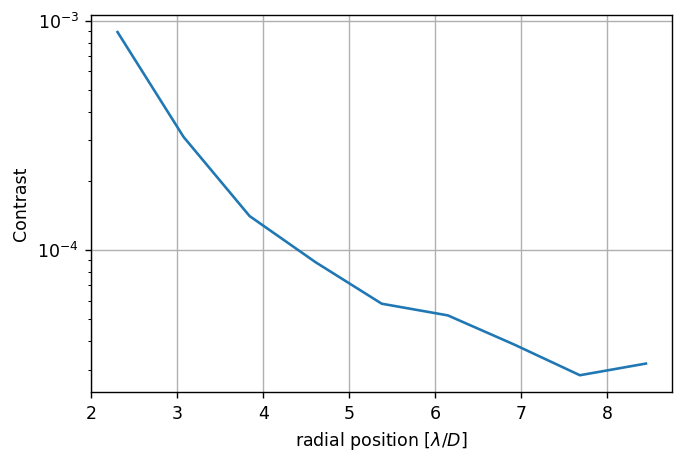

	Running iteration 17/50.


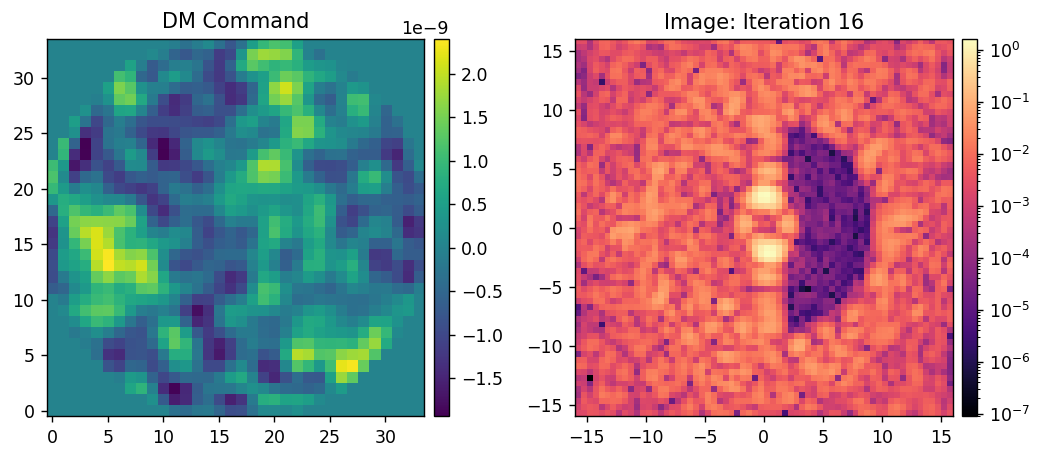

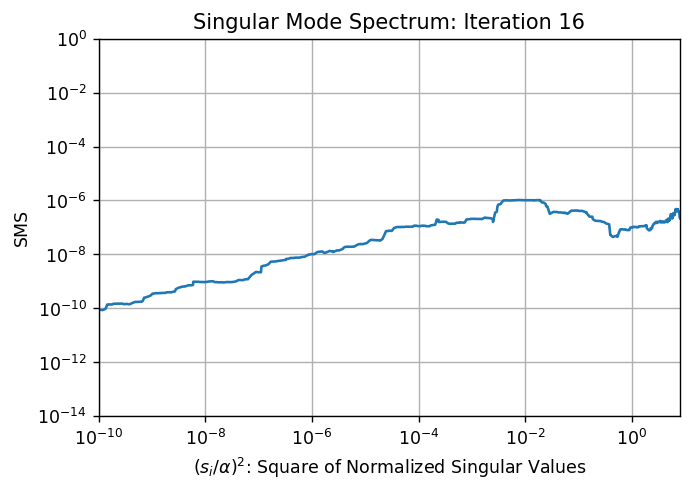

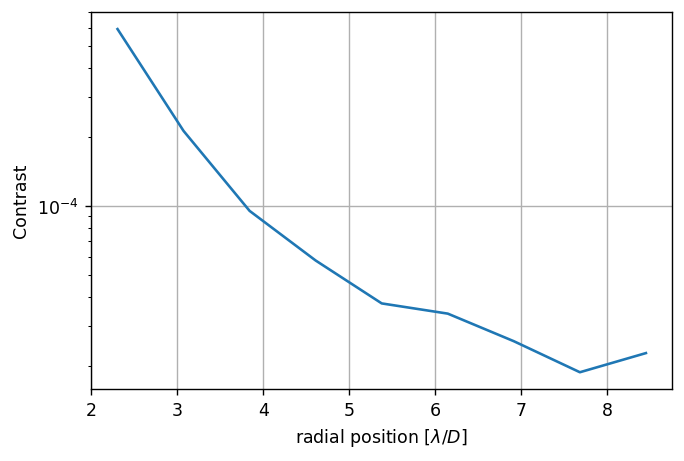

	Running iteration 18/50.


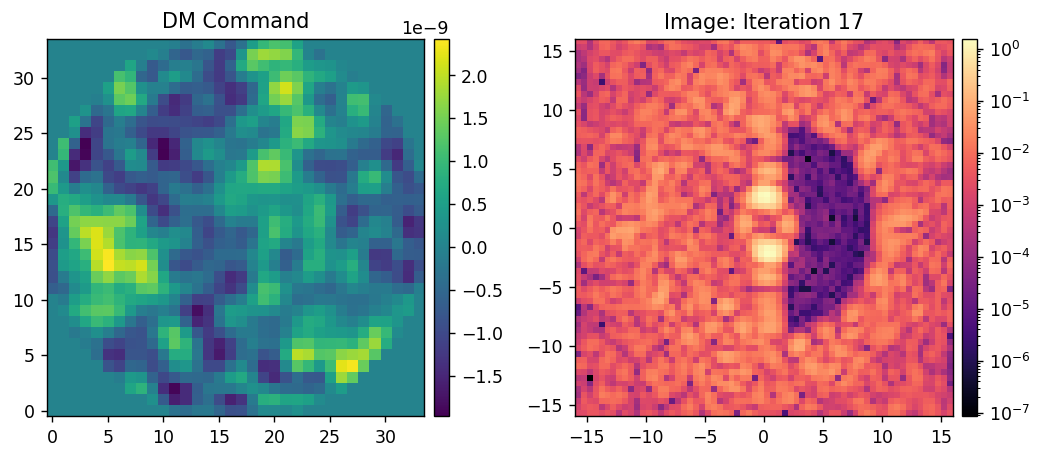

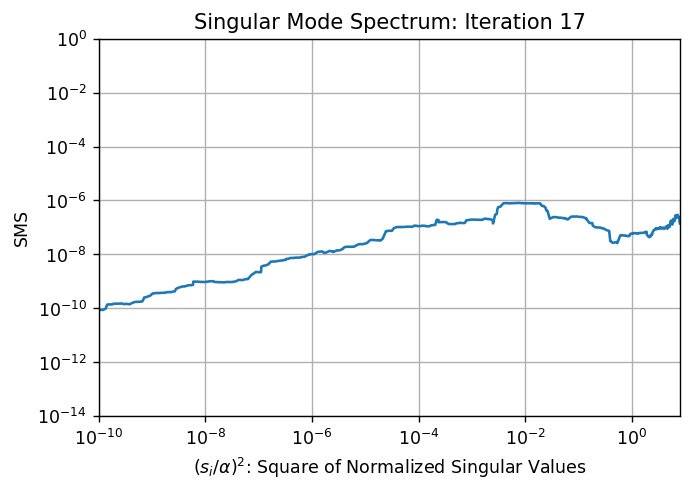

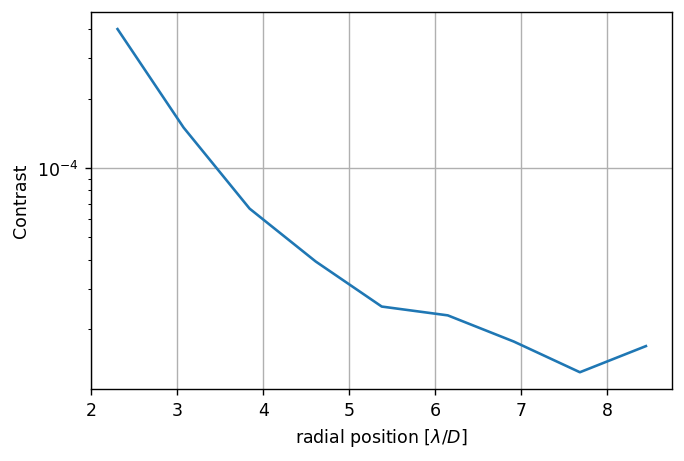

	Running iteration 19/50.


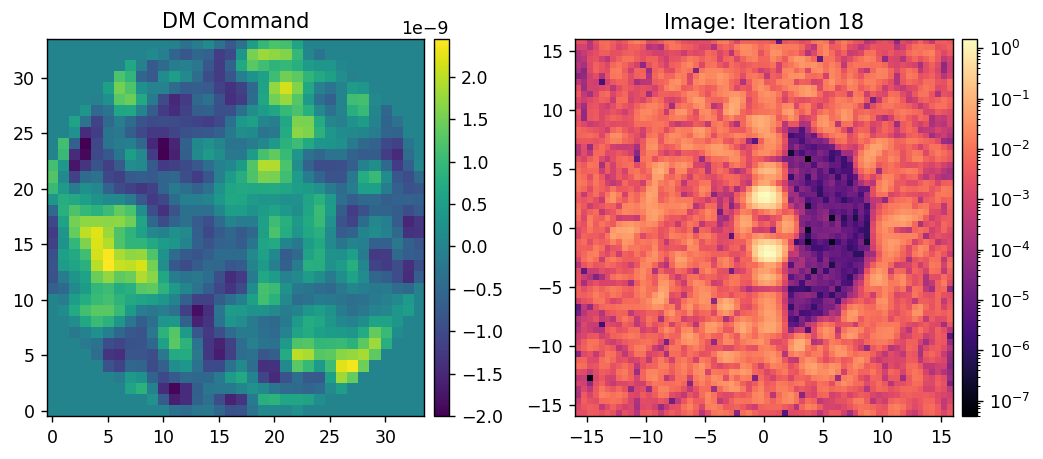

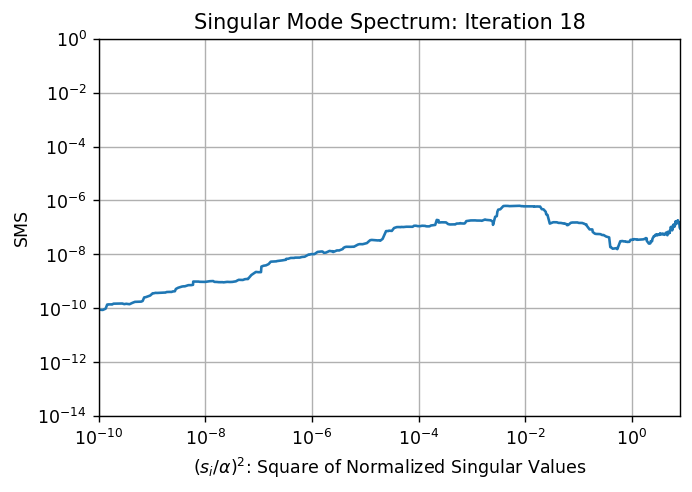

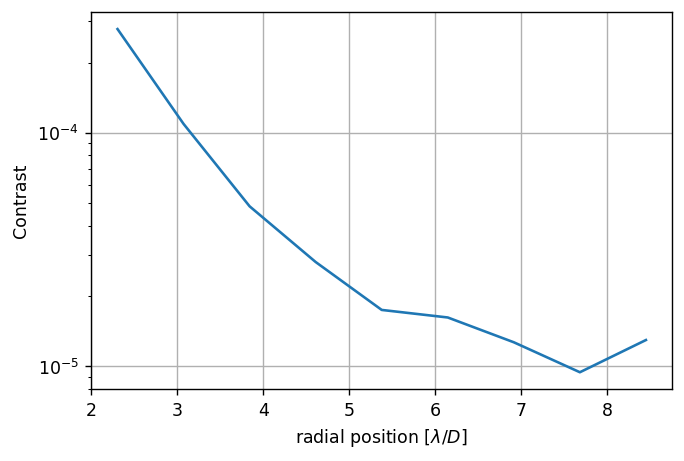

	Running iteration 20/50.


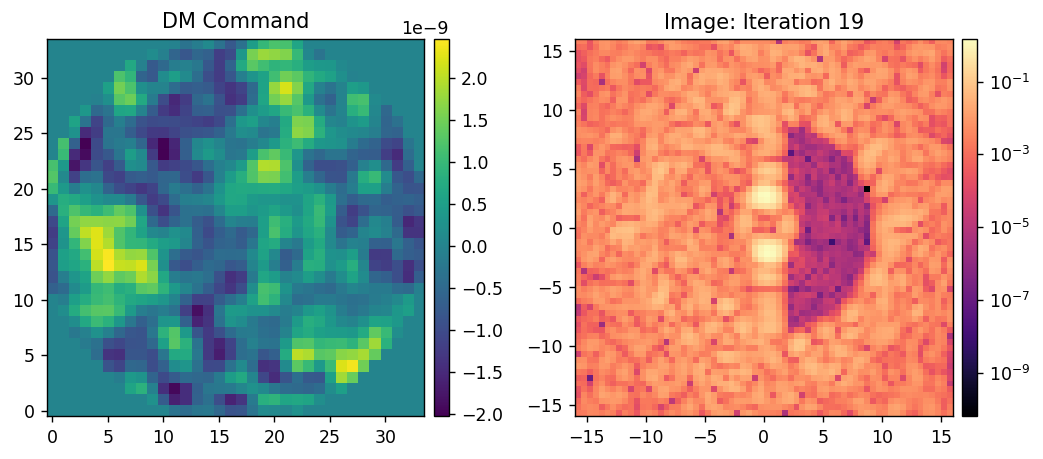

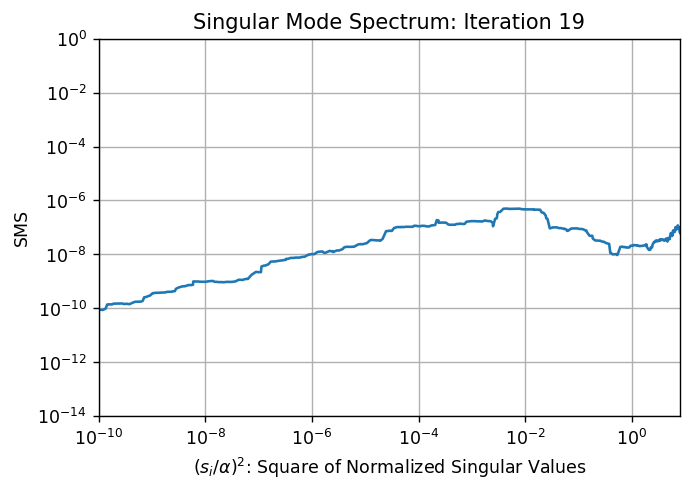

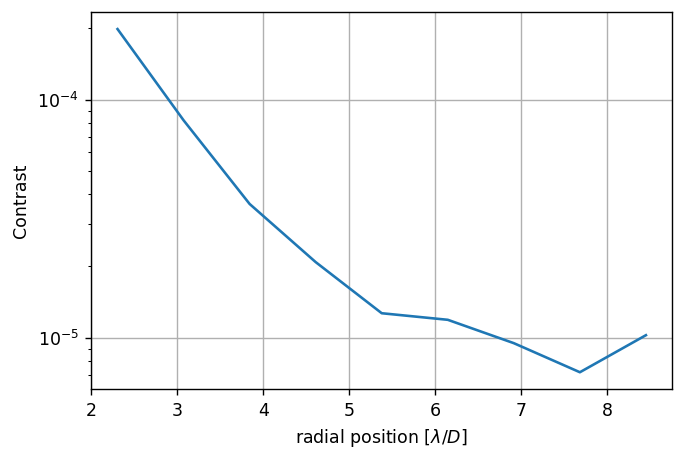

	Running iteration 21/50.
	Computing EFC matrix via beta_reg with condition value -3.00e+00


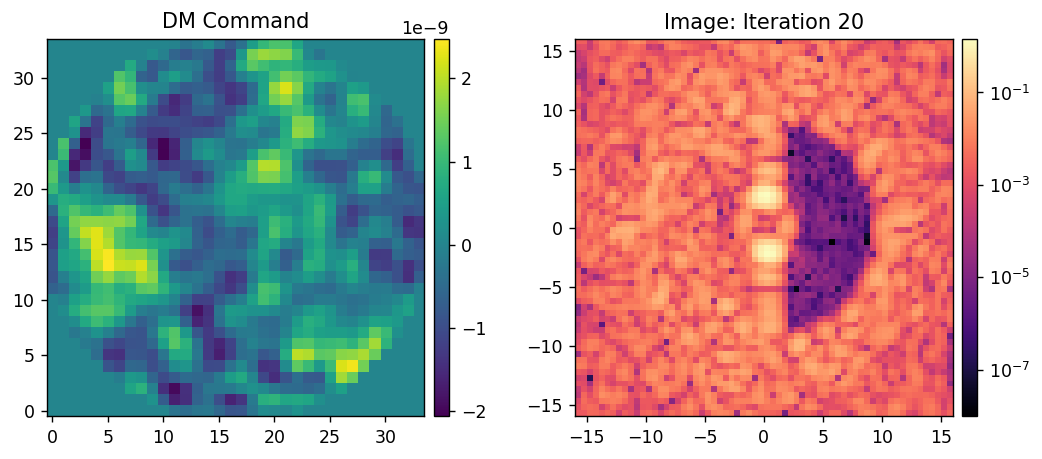

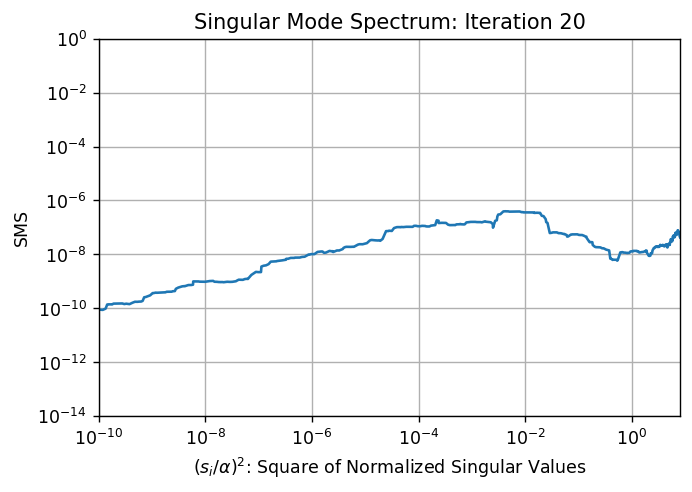

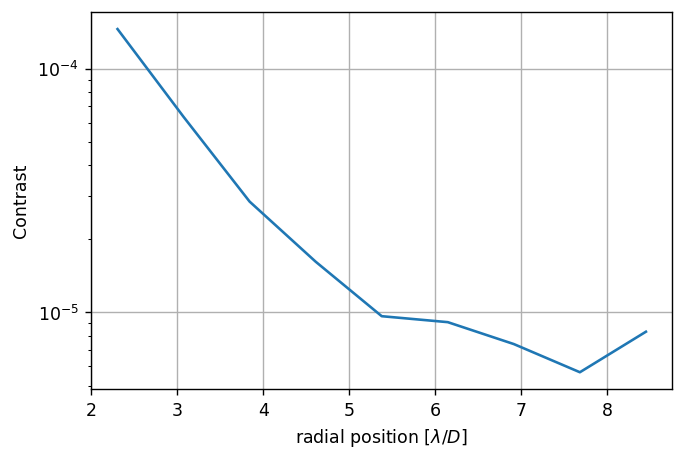

	Running iteration 22/50.


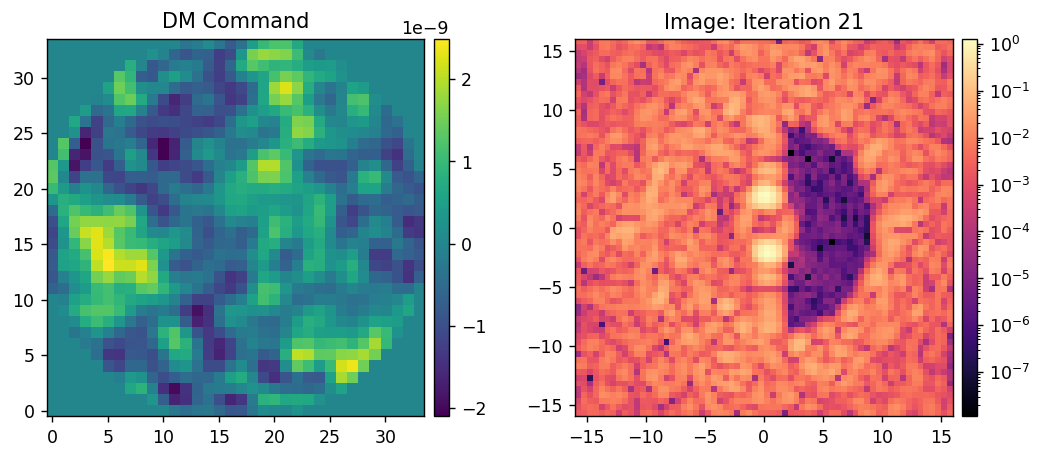

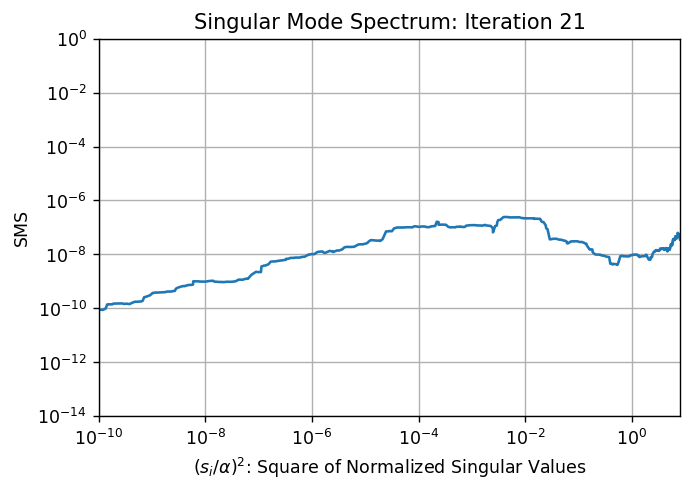

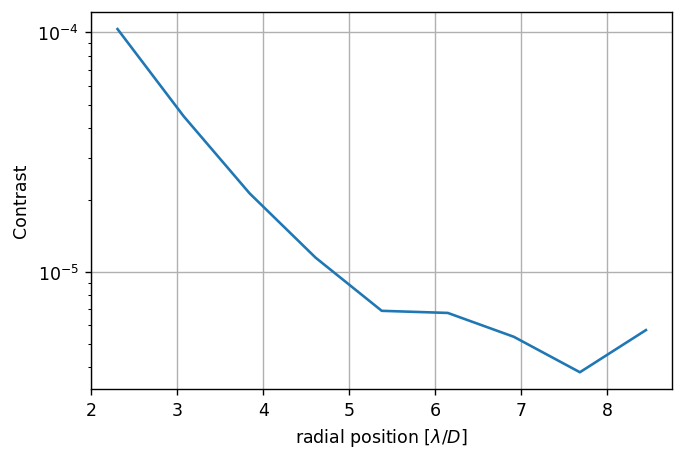

In [ ]:
reload(wfsc.efc_1dm)
reload(wfsc.utils)

c.reset_dms()

ims, commands = wfsc.efc_1dm.run_efc_perfect(c, 
                    jac, 
                    reg_fun,
                    reg_conds,
                    dark_mask, 
                    Imax_unocc=1,
                    efc_loop_gain=0.5, 
                    iterations=50, 
                    plot_all=True, 
                    plot_current=True,
                    plot_sms=True,
                                            plot_radial_contrast=True)